In [1]:
from fast_cleaning import fast_cleaning_longer, fast_cleaning_merge
from validation import get_efficiency, get_fake_rate, get_purity
from cleaning_old_longer import cleaning_old_longer
from cleaning_old_merge import cleaning_old_merge
from coating_cleaning import coating_cleaning
from validation import get_duplication_rate
from matplotlib import pyplot as plt
from copy import deepcopy
from get_data import *
from time import time
import pandas as pd
import matplotlib
import os


# Create variables for analyse

In [2]:
path = "data"
event_list = os.listdir(path)[:30]
cleaning_type_list = ["raw",
                      "cleaning_old_longer",
                      "cleaning_old_merge",
                      "fast_cleaning_longer",
                      "fast_cleaning_merge",
                      "coating_cleaning"]

cleaning_func_list = [list,
                      cleaning_old_longer,
                      cleaning_old_merge,
                      fast_cleaning_longer,
                      fast_cleaning_merge,
                      coating_cleaning]
plot_title = ["Efficiency",
              "Number of tracks left",
              # "Fake rate",
              "Duplicates",
              "Purity"]

# Create data objects for store information

In [3]:
event_list = [event_list[i:i + 3] for i in range(0, len(event_list), 3)]
df_efficiency = pd.DataFrame(columns=cleaning_type_list)
df_time = pd.DataFrame(columns=cleaning_type_list)
# df_fake_rate = pd.DataFrame(columns=cleaning_type_list)
df_tracks_number = pd.DataFrame(columns=cleaning_type_list)
df_duplicate = pd.DataFrame(columns=cleaning_type_list)
df_purity = pd.DataFrame(columns=cleaning_type_list)

# Collect statistics of all types of cleaning

In [4]:
for event_number, event in enumerate(event_list):
    track_file = event[0]
    hit_file = event[1]
    id_file = event[2]

    tracks = get_tracks_data(f'{path}/{track_file}', f'{path}/{hit_file}')
    hits = get_hits_data_for_validation(f'{path}/{hit_file}')
    track_id_list = get_track_id(f'{path}/{id_file}')

    print(f"###############################{event_number}/{len(event_list)}###############################")
    if not len(tracks) or not len(hits):
        print("ZERO")
        continue

    for cleaning_type, cleaning_func in zip(cleaning_type_list, cleaning_func_list):
        s = time()
        cleaned_tracks = cleaning_func(deepcopy(tracks))
        df_time.at[event_number, cleaning_type] = time() - s
        df_tracks_number.at[event_number, cleaning_type] = len(cleaned_tracks)
        df_efficiency.at[event_number, cleaning_type] = get_efficiency(cleaned_tracks, hits, track_id_list)
        # df_fake_rate.at[event_number, cleaning_type] = get_fake_rate(cleaned_tracks, hits,track_id_list)
        df_duplicate.at[event_number, cleaning_type] = get_duplication_rate(cleaned_tracks, hits, track_id_list)
        df_purity.at[event_number, cleaning_type] = get_purity(cleaned_tracks, hits, track_id_list)

###############################0/10###############################
Number of reco tracks: 184
Number of real selected tracks: 441
Number of fake tracks: 1
Number of real selected tracks: 4204
Number of real reco tracks: 5138
Number of reco tracks: 10162
Number of real reco tracks: 184
Number of reco tracks: 10162
Before cleaning there are 10162 tracks
Starting the first stage of merging duplicates
The first stage of merging completed in 4.427998065948486 seconds
Starting the second stage of merging duplicates
The second stage of merging completed in 21.362030029296875 seconds
Starting separate tracks
Track separating completed in 2.1009719371795654 seconds
Staring sorting the points in the track
Sorting completed in 1.7569561004638672 seconds
After cleaning there are 1809 tracks
Number of reco tracks: 182
Number of real selected tracks: 441
Number of fake tracks: 0
Number of real selected tracks: 149
Number of real reco tracks: 15
Number of reco tracks: 1809
Number of real reco tracks:

# Drawing

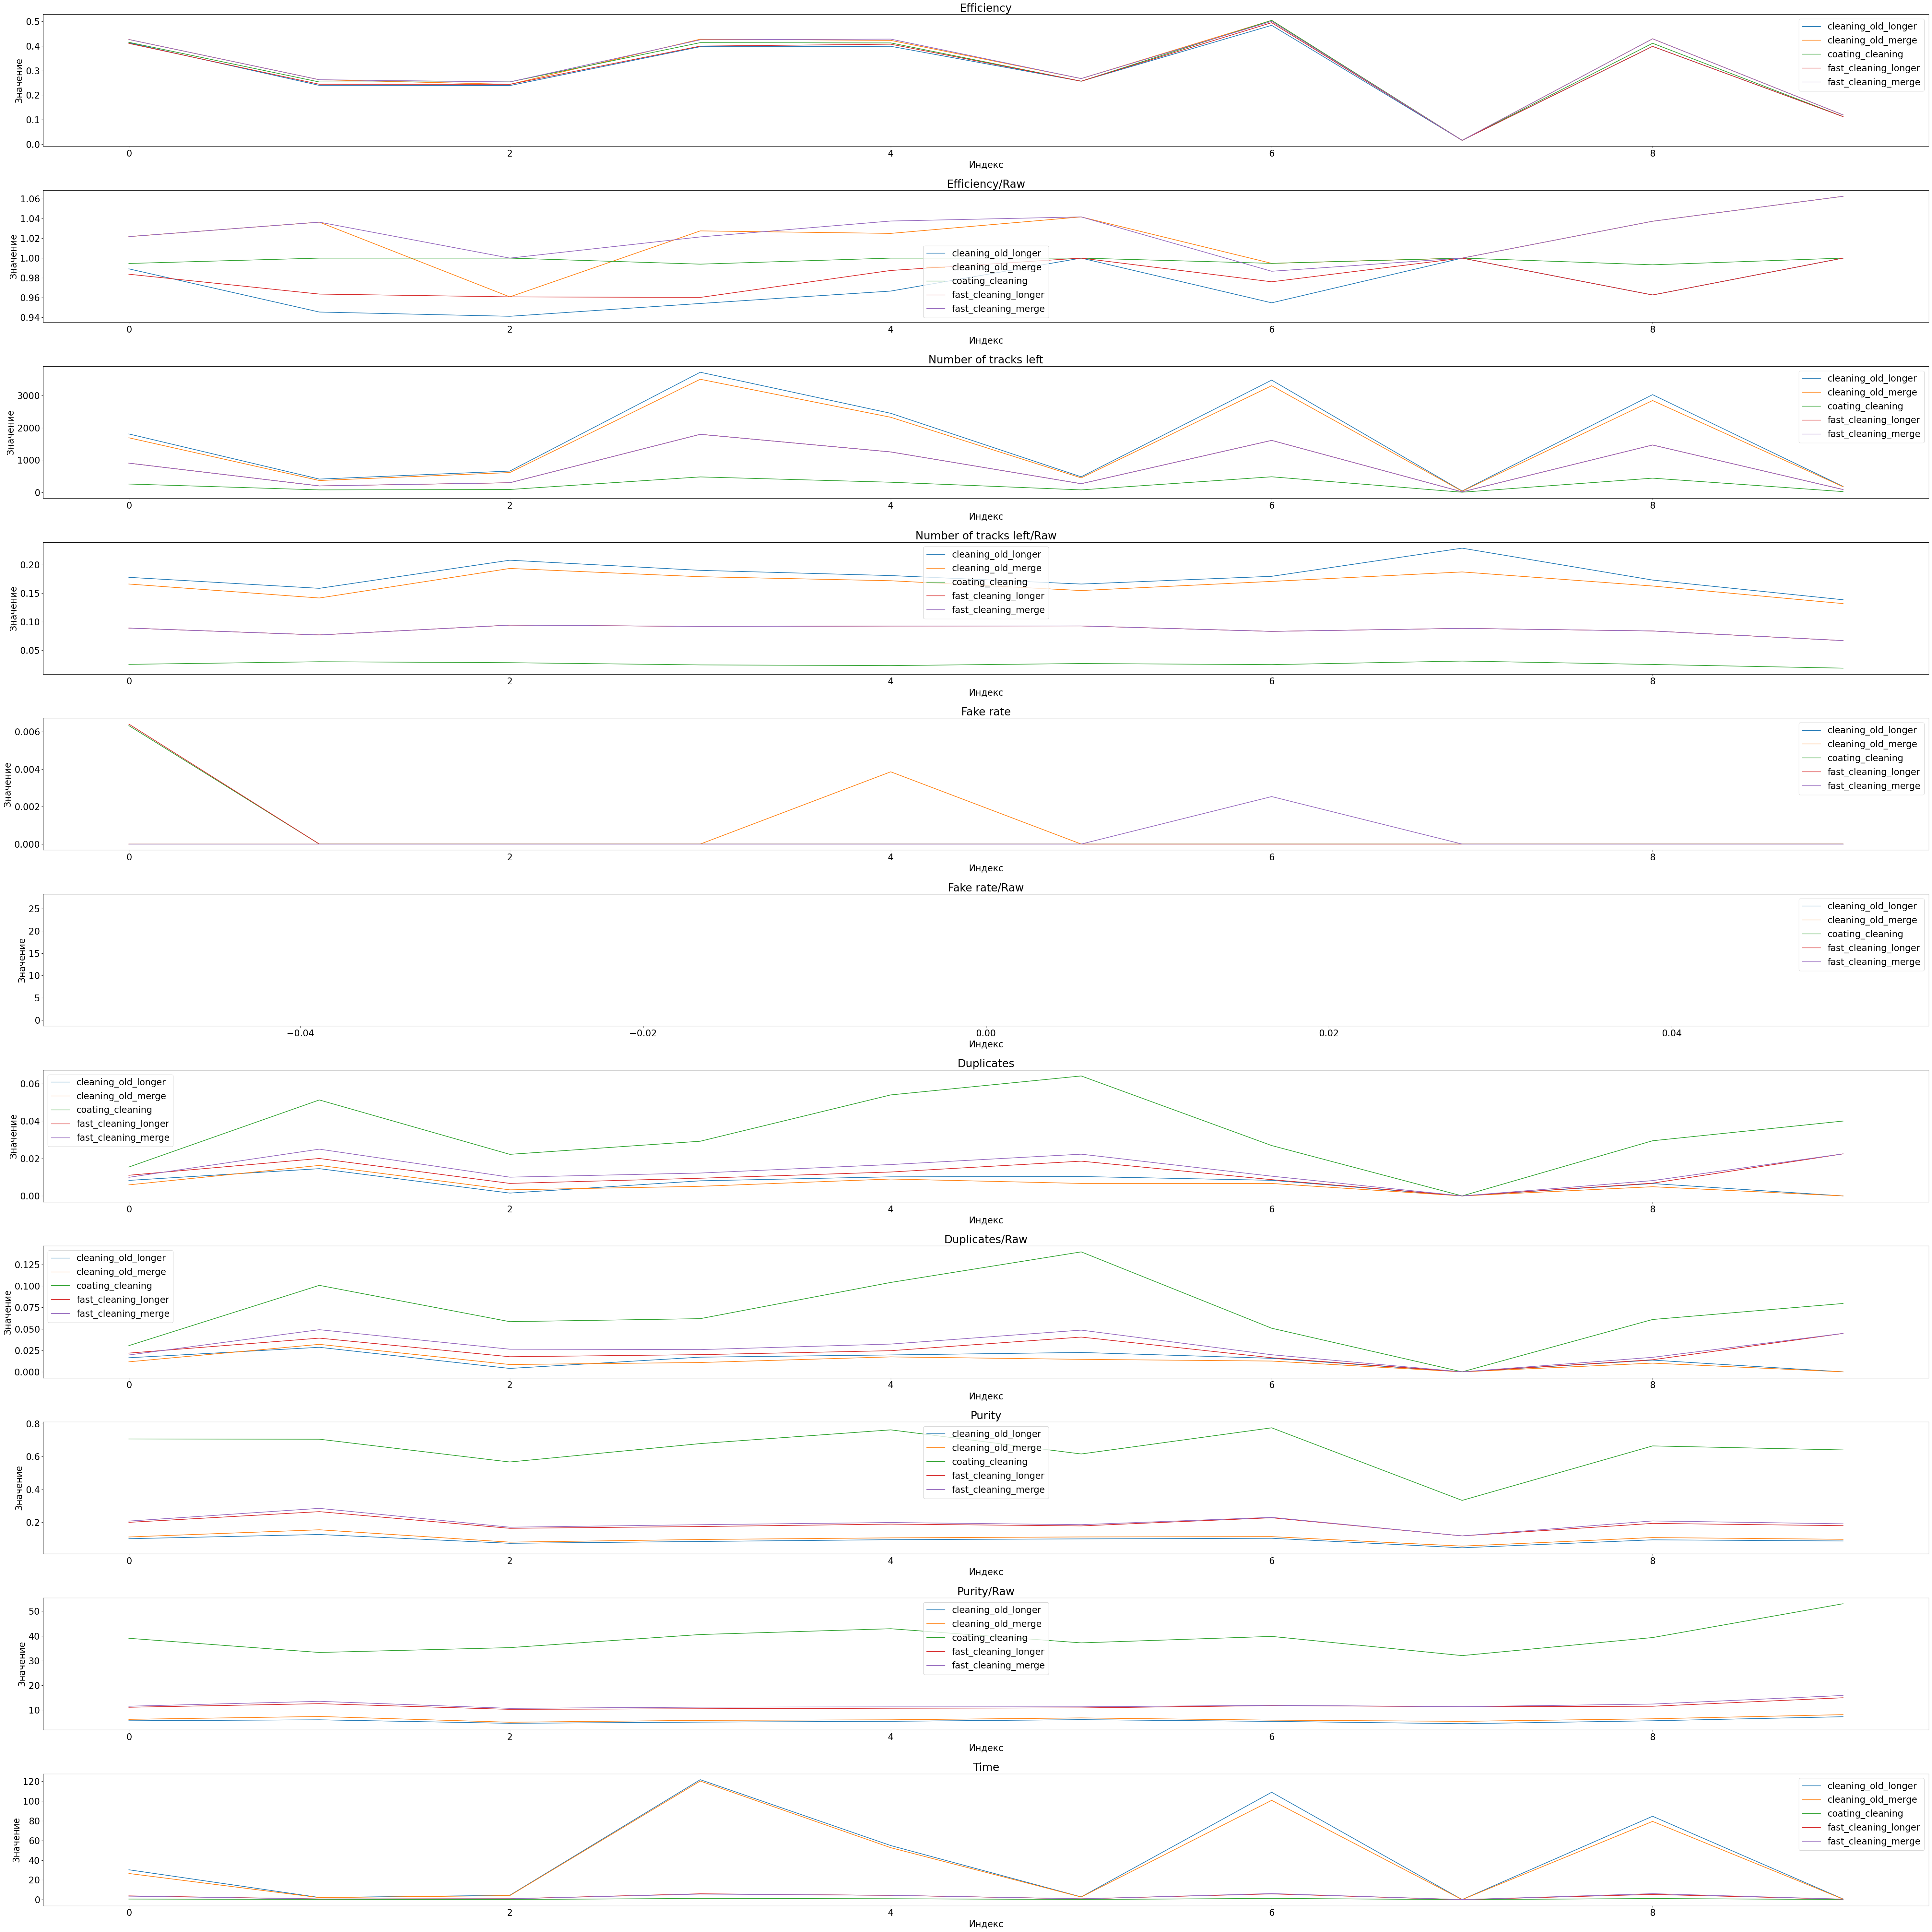

In [5]:
matplotlib.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(9, 1, figsize=(60, 60))

df_list = [df_efficiency, df_tracks_number, df_duplicate, df_purity]
for plot_id, df_id in zip(range(0, (len(df_list) + 1) * 2, 2), range(len(df_list))):
    df_normalized = df_list[df_id][df_list[df_id]["raw"] != 0]
    df_normalized = df_normalized.div(df_normalized["raw"], axis=0)

    for j, df in enumerate([df_list[df_id], df_normalized]):
        for column in df.columns.difference(["raw"]):
            axs[plot_id + j].plot(df.index, df[column], label=column)
        axs[plot_id + j].set_xlabel("Индекс")
        axs[plot_id + j].set_ylabel("Значение")
        axs[plot_id + j].set_title(plot_title[df_id] + "/Raw" if j else plot_title[df_id])
        axs[plot_id + j].legend()

for column in df_time.columns.difference(["raw"]):
    axs[len(df_list) * 2].plot(df_time.index, df_time[column], label=column)
axs[len(df_list) * 2].set_xlabel("Индекс")
axs[len(df_list) * 2].set_ylabel("Значение")
axs[len(df_list) * 2].set_title('Time')
axs[len(df_list) * 2].legend()

plt.tight_layout()
plt.show()